# MNIST in Pytorch

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

In [3]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

# Download MNIST training dataset and load training data
trainset = datasets.MNIST('.pytorch/MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download MNIST test dataset and load test data
testset = datasets.MNIST('.pytorch/MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Extracting .pytorch/MNIST/MNIST\raw\train-images-idx3-ubyte.gz to .pytorch/MNIST/MNIST\raw


Extracting .pytorch/MNIST/MNIST\raw\train-labels-idx1-ubyte.gz to .pytorch/MNIST/MNIST\raw


Extracting .pytorch/MNIST/MNIST\raw\t10k-images-idx3-ubyte.gz to .pytorch/MNIST/MNIST\raw


Extracting .pytorch/MNIST/MNIST\raw\t10k-labels-idx1-ubyte.gz to .pytorch/MNIST/MNIST\raw
Processing...
Done!


c:\program files\python37\lib\site-packages\torchvision\datasets\mnist.py:439: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
class MNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)

  def forward(self, x):
    x = x.view(x.shape[0], -1) # flatten the input

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)

    return x

model = MNIST()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
model.to(device)
num_epochs = 30
train_tracker, test_tracker, accuracy_tracker = [], [], []


for i in range(num_epochs):
    cum_loss = 0

    for batch, (images, labels) in enumerate(trainloader,1):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        cum_loss += loss.item()

    train_tracker.append(cum_loss/len(trainloader))
    print(f"Epoch({i+1}/{num_epochs}) | Training loss: {cum_loss/len(trainloader)} | ",end='')

    test_loss = 0
    num_correct = 0
    total = 0

    for batch, (images, labels) in enumerate(testloader,1):
        images = images.to(device)
        labels = labels.to(device)

        logps = model(images)
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()

        output = torch.exp(logps)
        pred = torch.argmax(output, 1)
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()

    test_tracker.append(test_loss/len(testloader))
    print(f"Test loss: {test_loss/len(testloader)} | ", end='')
    accuracy_tracker.append(num_correct/total)
    print(f'Accuracy : {num_correct/total}')
print(f'\nNumber correct : {num_correct}, Total : {total}')
print(f'Accuracy of the model after 30 epochs on the 10000 test images: {num_correct * 100 / total}% ')


Epoch(1/30) | Training loss: 0.44389019456944234 | Test loss: 0.39746663354005024 | Accuracy : 0.8936
Epoch(2/30) | Training loss: 0.39540783373086946 | Test loss: 0.3614453232497167 | Accuracy : 0.9006
Epoch(3/30) | Training loss: 0.36688865049243735 | Test loss: 0.3399962809197842 | Accuracy : 0.9032
Epoch(4/30) | Training loss: 0.34689833647978585 | Test loss: 0.32951100263151395 | Accuracy : 0.9062
Epoch(5/30) | Training loss: 0.33182546221561776 | Test loss: 0.3129959406604053 | Accuracy : 0.9132
Epoch(6/30) | Training loss: 0.3199413687562637 | Test loss: 0.30001256835593537 | Accuracy : 0.9147
Epoch(7/30) | Training loss: 0.30949221361579415 | Test loss: 0.29360178928039254 | Accuracy : 0.9167
Epoch(8/30) | Training loss: 0.3004443007491545 | Test loss: 0.285769663952813 | Accuracy : 0.9172
Epoch(9/30) | Training loss: 0.2926212318384571 | Test loss: 0.2780749164758974 | Accuracy : 0.9212
Epoch(10/30) | Training loss: 0.28480551475242005 | Test loss: 0.27231041862848837 | Accura

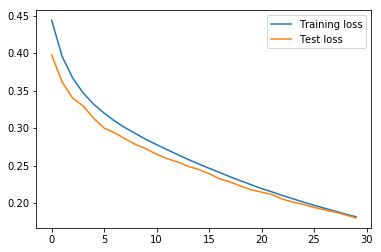

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
plt.plot(test_tracker, label='Test loss')
plt.legend()

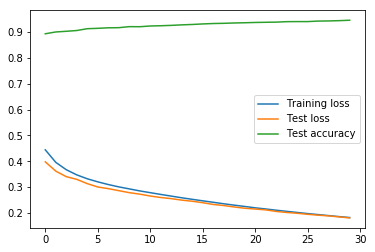

In [9]:
plt.plot(train_tracker, label='Training loss')
plt.plot(test_tracker, label='Test loss')
plt.plot(accuracy_tracker, label='Test accuracy')
plt.legend()

In [13]:
images, labels = next(iter(testloader))

test_image_id = 6
img = images[test_image_id].view(1, 784)

with torch.no_grad():
    logps = model(img)

<BarContainer object of 10 artists>

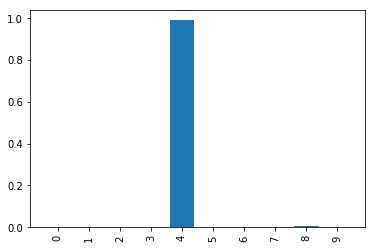

In [14]:
ps = torch.exp(logps)
nps = ps.numpy()[0]
MNIST_labels = [str(i) for i in range(10)]
plt.xticks(np.arange(10),labels=MNIST_labels,rotation='vertical')
plt.bar(np.arange(10), nps)

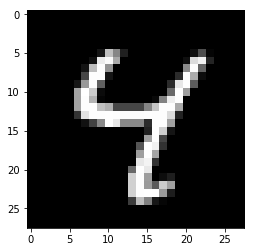

In [15]:
def denormalize(tensor):
  tensor = tensor*0.5 + 0.5
  return tensor

img = img.view(28,-1)
img = denormalize(img)
plt.imshow(img,cmap='gray')